# Demo: scikit-learn pipelines

This notebook demonstrates how a machine learning pipeline can be built with the scikit-learn pipeline framework.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

Let's create some data and visualize it. 

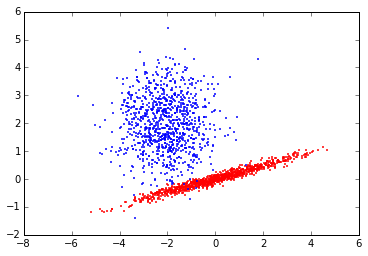

In [2]:
# Number of samples per component
n_samples = 1000

# Generate random sample, two classes
np.random.seed(0)
cov1 = np.array([[0., -0.1], [1.7, .4]])
mean1 = np.array([0, 0])
cov2 = np.array([[1.0, 0.0], [0.0, 1.0]])
mean2 = np.array([-2, 2])
                 
X = np.r_[
    np.dot(np.random.randn(n_samples, 2), cov1) + mean1, 
    np.dot(np.random.randn(n_samples, 2), cov2) + mean2
]
y = np.concatenate([np.ones(n_samples), -np.ones(n_samples)])

plt.scatter(X[y == +1, 0], X[y == +1, 1], .8, color='red')
plt.scatter(X[y == -1, 0], X[y == -1, 1], .8, color='blue')

Our goal is to learn a classifier for these two classes. In our example, we use a logistic regression.

In [3]:
classifier = LogisticRegression()

The logistic regression provides us with a probability for each class. The expectation of a probability is that it is well-calibrated, i.e., a probability of 90% of the red class for a specific instance should really mean that over all examples with a probability of 90%, exactly 10% are actually of the blue class. Perplexity measures that aspect.

In [4]:
from scipy.stats import gmean
    
def perplexity(estimator, X, y):
    likelihoods = [p if t == 1.0 else 1-p for (t, p) in zip(y, estimator.predict_proba(X).T[1])]
    return gmean(likelihoods)

The logistic regression is a predictive model that can be framed as regularized empirical risk estimator. These estimators trade-off a minimal training error against model complexity, penalized by a regularization term. A typical choice is the Lp-norm that corresponds to a spherical covariance matrix (scale of the identify matrix) assumption. This means that all features are assumpted to be zero-centered and have roughly the same variance. To ensure that, we apply a z-normalization. 

In [5]:
feature_normalization = StandardScaler()

In some applications, we are interested in a small number of most discriptive features. There are different ways to do that and the sklearn framework provides some implementations. To demonstrate that, let us assume that we would like find only the best feature.

In [6]:
feature_selection = SelectKBest(score_func=f_classif, k=1)

These steps belong together: whenever we would like to classify an instance, we need to normalize it's features and run the classifier. The normalization constants, the best feature(s), and the model parameters are inferred at training time. The pipeline framework allows us to group them together.

In [7]:
pipeline = Pipeline([
    ('preprocessing', feature_normalization),
    ('features-selection', feature_selection),
    ('classifier', classifier),
])

The aforementioned trade-off between model complexity and training error is a hyper-parameter, which means that it is assumed to be given for the estimation of the model parameters. It is typically optimized via grid search. Note, that we need use the pipeline as a whole in order to find the parameter that generalizes most.

Note, that we could also optimized the number of features to be selected. This can easily be done, by extending `param_grid` by `features_selection__k`.

In [8]:
Cs = np.logspace(-3, 3, 7)
pipelineOptimalC = GridSearchCV(
    estimator=pipeline,
    scoring=perplexity,
    param_grid={
        'classifier__C': Cs
    }
)

An realistic estimate of the perplexity of the protocol encrypted by this pipeline is obtained by cross validation.

In [9]:
cross_val_score(pipelineOptimalC, X, y, scoring=perplexity, cv=5).mean()

0.82695026244002323

This is an estimate of the procedure that produces a predictive model. Now, we train the final model.

In [10]:
pipelineOptimalC = pipelineOptimalC.fit(X, y).best_estimator_
classifierOptimalC = pipelineOptimalC.named_steps['classifier']
optimalFeatureSelection = pipelineOptimalC.named_steps['features-selection']

Note, that the optimal hyperparameter was estimated in an inner CV.

In [11]:
classifierOptimalC.C

10.0

Finally, let's plot the result.

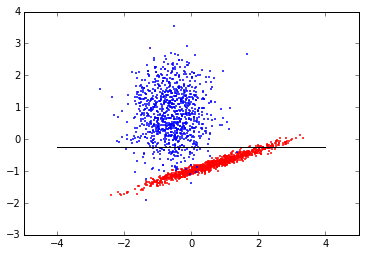

In [12]:
Xt = pipelineOptimalC.named_steps['preprocessing'].transform(X)
plt.scatter(Xt[y == +1, 0], Xt[y == +1, 1], .8, color='red')
plt.scatter(Xt[y == -1, 0], Xt[y == -1, 1], .8, color='blue')

def eval_linear(x, w, intercept):
    """
    Evaluate x_2 for a given x_1, s.t. (x_1, x_2) lies on the 2d hyperplane (w,intercept)
    """
    m = -w[0]/w[1]
    n = -intercept/w[1]
    y = m*x+n
    return y

xvals = np.array(plt.xlim())
# keep two dimensions two plot
w = np.array([10E-10, 10E-10])
w[optimalFeatureSelection.get_support()] = classifierOptimalC.coef_[0]
yvals = eval_linear(xvals, w, classifierOptimalC.intercept_[0])
plt.plot(xvals, yvals, color='black')